<a href="https://colab.research.google.com/github/StevenJUlbrich/2022-facade/blob/main/Copy_of_Reference_Notebook_Malaria_Detection_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [1]:
# Mount my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [2]:
import numpy as np # linear algebra and array work
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import cv2 # image processing resizes images and augmentations
import tensorflow as tf # machine learning
from tensorflow.keras import layers, models, optimizers, Input, Sequential # machine learning
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras.applications import VGG16 #, ResNet50, InceptionV3, Xception, MobileNetV2, EfficientNetB0 # pre-trained models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # machine learning
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split # splitting data
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report # model evaluation
from PIL import Image
import io # file handling
import zipfile
import os # file handling
import random # random number generation
import glob # file handling


### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [3]:
# path to the training data directory
zip_data_dir = '/content/drive/MyDrive/Malaria/cell_images.zip'


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [4]:

def load_images_from_zip(zip_path, img_size=(64, 64), convert_to_hsv=False):
    """
    Load PNG images from a zip file and prepare them for CNN input.
    Optionally convert images to HSV color space.

    Args:
        zip_path (str): Path to the zip file containing image directories.
        img_size (tuple): Desired size for the images. Defaults to (64, 64).
        convert_to_hsv (bool): Whether to convert images to HSV. Defaults to False.

    Returns:
        tuple: Four numpy arrays:
               - train_images: 4D array of training images (samples, height, width, channels)
               - train_labels: 1D array of training labels
               - test_images: 4D array of test images (samples, height, width, channels)
               - test_labels: 1D array of test labels
    """
    train_images, train_labels = [], []
    test_images, test_labels = [], []
    categories = {'parasitized': 1, 'uninfected': 0}

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for dataset in ['train', 'test']:
            for category, label in categories.items():
                file_list = [f for f in zip_ref.namelist()
                             if f.startswith(f'cell_images/{dataset}/{category}/')
                             and f.lower().endswith('.png')]

                for file_path in file_list:
                    with zip_ref.open(file_path) as file:
                        img = Image.open(io.BytesIO(file.read())).convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img)

                        if convert_to_hsv:
                            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)

                        if dataset == 'train':
                            train_images.append(img_array)
                            train_labels.append(label)
                        else:
                            test_images.append(img_array)
                            test_labels.append(label)

    # Convert lists to numpy arrays
    train_images = np.array(train_images, dtype=np.float32) / 255.0
    train_labels = np.array(train_labels)
    test_images = np.array(test_images, dtype=np.float32) / 255.0
    test_labels = np.array(test_labels)

    print(f"Loaded {len(train_images)} training images and {len(test_images)} test images.")
    print(f"Color space: {'HSV' if convert_to_hsv else 'RGB'}")

    return train_images, train_labels, test_images, test_labels

In [5]:
# Load and process the training  and test images png format
image_size = (64, 64)
train_images, train_labels, test_images, test_labels = load_images_from_zip(zip_data_dir, img_size=image_size, convert_to_hsv=False)

Loaded 24958 training images and 2600 test images.
Color space: RGB


###<b> Check the shape of train and test images

In [6]:
print(f'Training images shape: {train_images.shape}')

Training images shape: (24958, 64, 64, 3)


In [7]:
print(f'Test images shape: {test_images.shape}')

Test images shape: (2600, 64, 64, 3)


###<b> Check the shape of train and test labels

In [8]:
print(f'Training labels shape: {train_labels.shape}')

Training labels shape: (24958,)


In [9]:
print(f'Test labels shape: {test_labels.shape}')

Test labels shape: (2600,)


####<b> Observations and insights: The images in the train and test sections of the code match the stated requirements.

### <b>Check the minimum and maximum range of pixel values for train and test images

In [10]:
# Check the minimum and maximum pixel values for train images
min_pixel_train = train_images.min()
max_pixel_train = train_images.max()

print(f'Minimum pixel value in train images: {min_pixel_train}')
print(f'Maximum pixel value in train images: {max_pixel_train}')


Minimum pixel value in train images: 0.0
Maximum pixel value in train images: 1.0


In [11]:
# Check the minimum and maximum pixel values for test images
min_pixel_test = test_images.min()
max_pixel_test = test_images.max()

print(f'Minimum pixel value in test images: {min_pixel_test}')
print(f'Maximum pixel value in test images: {max_pixel_test}')

Minimum pixel value in test images: 0.0
Maximum pixel value in test images: 1.0


####<b> Observations and insights: At this time, I have  already normalized the images. So the range is from the minimun to the max value of the 0 to 1 range. It can be deduced that the range prior to the normalization would be 0 to 255.



###<b> Count the number of values in both uninfected and parasitized


code will count the number of parasitized (label 1) and uninfected (label 0) samples in both your training and test sets, and then give you the total counts.

In [12]:
# For training set
train_parasitized = np.sum(train_labels == 1)
train_uninfected = np.sum(train_labels == 0)

print("Training set:")
print(f"Parasitized: {train_parasitized}")
print(f"Uninfected: {train_uninfected}")

# For test set
test_parasitized = np.sum(test_labels == 1)
test_uninfected = np.sum(test_labels == 0)

print("\nTest set:")
print(f"Parasitized: {test_parasitized}")
print(f"Uninfected: {test_uninfected}")


Training set:
Parasitized: 12582
Uninfected: 12376

Test set:
Parasitized: 1300
Uninfected: 1300


###<b>Normalize the images

#### The normalazation of the data took place in the method of loading the images from zip.  I don't see the need to find the min or max prior to normalizing the data.  if the data has large values it will be easy to see after normalization.

####<b> Observations and insights: The data provide is evenly devided between Parasitied and Uninfected. It covers the trainging and test sets.


###<b> Plot to check if the data is balanced

In [13]:
# The following functions count the number of occurrences of each value in the train_labels and test_labels arrays.
train_class_counts = np.bincount(train_labels)
test_class_counts = np.bincount(test_labels)


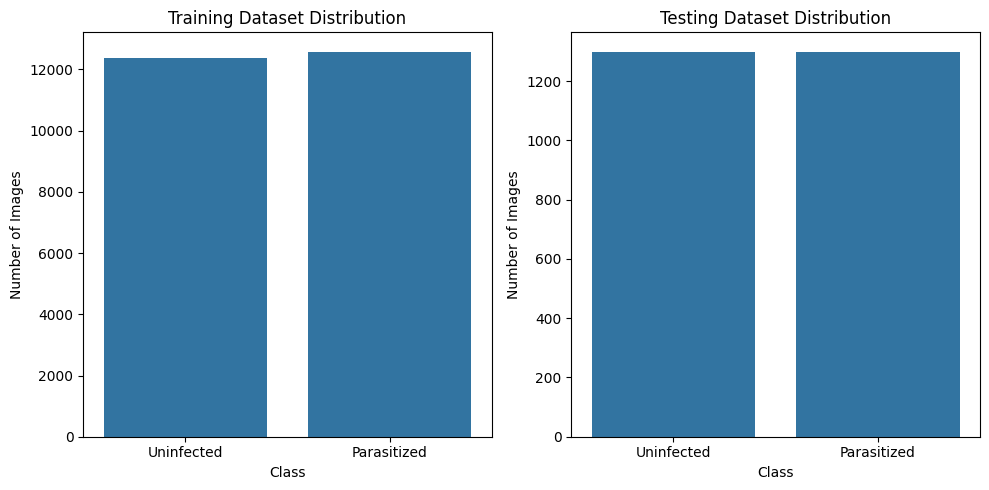

In [14]:
# Plot for training dataset
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
sns.barplot(x=['Uninfected', 'Parasitized'], y=train_class_counts)
plt.title('Training Dataset Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Plot for testing dataset
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
sns.barplot(x=['Uninfected', 'Parasitized'], y=test_class_counts)
plt.title('Testing Dataset Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

####<b> Observations and insights: The bars for both classes are of similar height in both datasets, the provided data is balanced. In constrast, if one bar is significantly higher than the other, it indicates that your dataset is imbalanced, which might require addressing through techniques like data augmentation, oversampling, or undersampling.

### <b>Data Exploration</b>
Let's visualize the images from the train data

1. random.randint(0, len(images) - 1): Generates a random index between 0 and the length of the image array minus one, ensuring a valid index.
2. plt.imshow(image): Displays the randomly selected image using Matplotlib.
3. plt.title(...): Sets the title of the plot to indicate whether the image is from the training or testing dataset and whether it is parasitized or uninfected.
4. plt.axis('off'): Hides the axis labels for a cleaner display.

In [15]:
# Lets randomly display some images from the training dataset and their corresponding labels
def display_random_image(images, labels, dataset_type):
    """
    Display a random image from the dataset along with its label.

    Args:
        images (numpy array): Array of images.
        labels (numpy array): Array of corresponding labels.
        dataset_type (str): Type of dataset ('train' or 'test') for display purposes.
    """
    index = random.randint(0, len(images) - 1)
    image = images[index]
    label = labels[index]

    # Check if the image is in HSV (3 channels and second channel should be 180 in most cases)
    if image.shape[-1] == 3 and image[:, :, 1].max() <= 255:
        try:
            # Attempt conversion from HSV to RGB
            image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        except Exception as e:
            print(f"Could not convert image from HSV to RGB: {e}")

    plt.imshow(image)
    plt.title(f'{dataset_type.capitalize()} Image - {"Parasitized" if label == 1 else "Uninfected"}')
    plt.axis('off')
    plt.show()

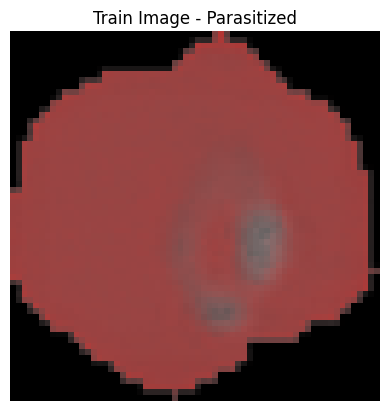

In [16]:
display_random_image(train_images, train_labels, 'train')

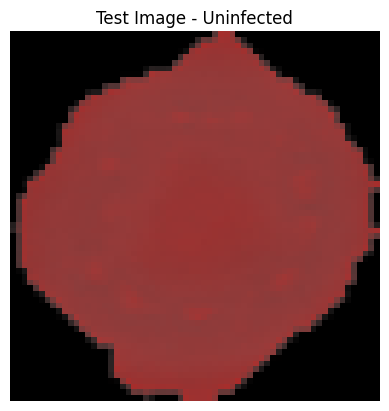

In [17]:
display_random_image(test_images, test_labels, 'test')

####<b> Observations and insights: The samples are different in respect to color saturation and focus points that could indicate infected blood sample.  Hoever the next set of impages could  be harder visual determine the difference without training.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

1. grid_size=(6, 6): Defines the grid size, creating a 6x6 grid for displaying images.
2. figsize=(12, 12): Specifies the size of the figure, making it large enough to clearly display all images.
3. plt.subplot(grid_size[0], grid_size[1], i): Creates a subplot in the specified grid position.
4. plt.suptitle(...): Adds a title above the entire grid to indicate whether the images are from the training or testing dataset.

In [18]:
def display_image_grid(images, labels, dataset_type, grid_size=(6, 6), figsize=(12, 12)):
    """
    Display a grid of random images from the dataset.

    Args:
        images (numpy array): Array of images.
        labels (numpy array): Array of corresponding labels.
        dataset_type (str): Type of dataset ('train' or 'test') for display purposes.
        grid_size (tuple): Tuple specifying the grid size (rows, columns).
        figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)

    for i in range(1, grid_size[0] * grid_size[1] + 1):
        index = random.randint(0, len(images) - 1)
        image = images[index]
        label = labels[index]

        # Check if the image is in HSV format
        if image.shape[-1] == 3 and image[:, :, 1].max() <= 255:
            try:
                # Convert from HSV to RGB for display
                image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
            except Exception as e:
                print(f"Could not convert image from HSV to RGB: {e}")

        plt.subplot(grid_size[0], grid_size[1], i)
        plt.imshow(image)
        plt.title(f'{"Parasitized" if label == 1 else "Uninfected"}')
        plt.axis('off')

    plt.suptitle(f'{dataset_type.capitalize()} Dataset - Random Sample of Images')
    plt.show()



 The display two separate grids of images: one for the training dataset and one for the testing dataset.
 Each grid will contain 36 randomly selected images, labeled as "Parasitized" or "Uninfected".

This visualization provides a comprehensive view of the dataset, helping in the the assess the diversity
and quality of the images. It's particularly useful for verifying that the images are correctly
labeled and that the dataset is balanced in terms of class representation.

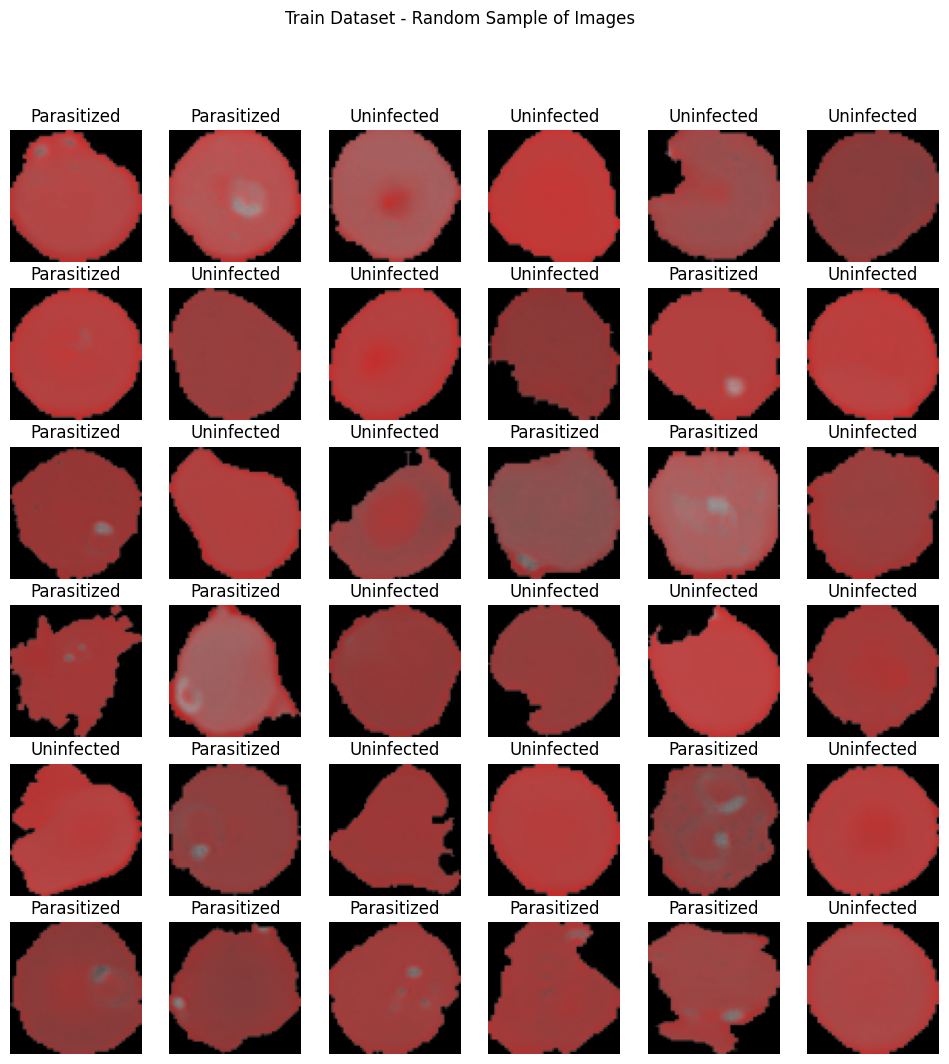

In [19]:
display_image_grid(train_images, train_labels, 'train')

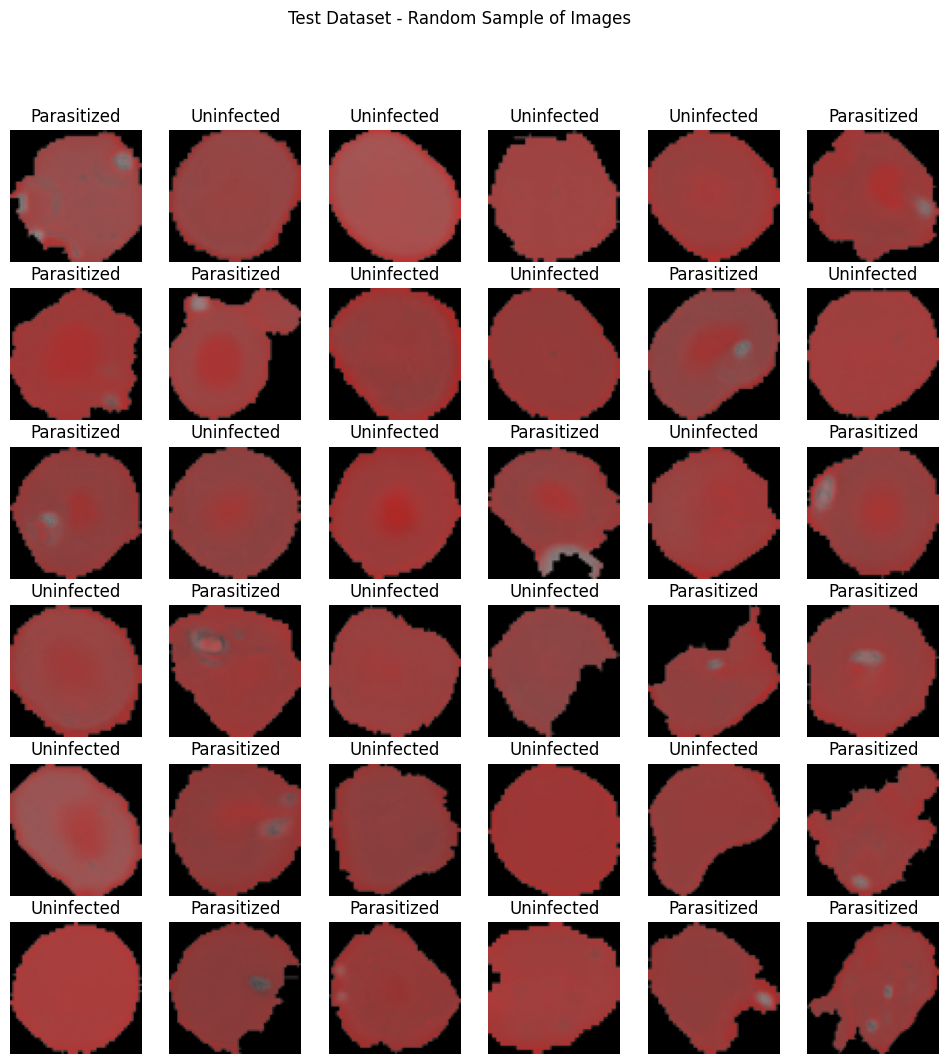

In [20]:
display_image_grid(test_images, test_labels, 'test')

####<b>Observations and insights: The quality and clarity of the images, as well as the correct representation of colors and textures, are vital for accurate classification. Ensuring that these factors are properly addressed in the proceeding preprocessing and training pipeline will significantly impact the model's performance. Given the suttle difference  of the visual differences between parasitized and uninfected cells,the quality of  dataset and potentially more advanced models are recommended to achieve accurate results.

The varaiation i nthe shapes and sized of the blood samples is expected.  As the detection of the parasites within the blood cell is the necessary point of the detection.

###<b> Plotting the mean images for parasitized and uninfected

In [21]:
def calculate_mean_image(images, labels, class_label):
    """
    Calculate the mean image for a specific class (Parasitized or Uninfected).

    Args:
        images (numpy array): Array of images.
        labels (numpy array): Array of corresponding labels.
        class_label (int): The class label to filter by (1 for Parasitized, 0 for Uninfected).

    Returns:
        numpy array: The mean image for the specified class.
    """
    # Filter images based on the specified class label
    class_images = images[labels == class_label]

    # Calculate the mean image by averaging across the filtered images
    mean_image = np.mean(class_images, axis=0)

    return mean_image

In [22]:
# Calculate the mean image for the "Parasitized" class (label = 1)
mean_parasitized_image = calculate_mean_image(train_images, train_labels, class_label=1)

# Calculate the mean image for the "Uninfected" class (label = 0)
mean_uninfected_image = calculate_mean_image(train_images, train_labels, class_label=0)


In [23]:
# Display the mean images
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<b> Mean image for parasitized

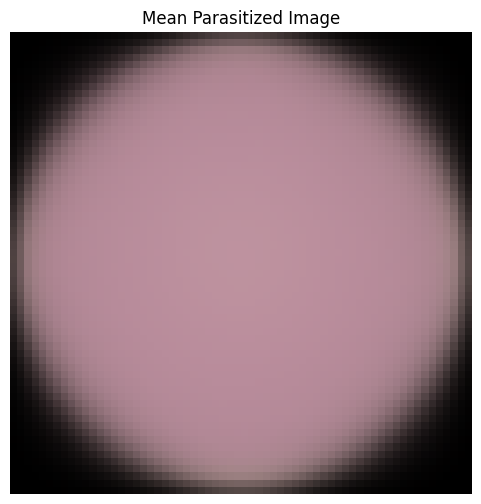

In [24]:
# Display the mean image for the "Parasitized" class
plt.figure(figsize=(6, 6))
plt.imshow(mean_parasitized_image.astype(np.float32))
plt.title('Mean Parasitized Image')
plt.axis('off')
plt.show()

<b> Mean image for uninfected

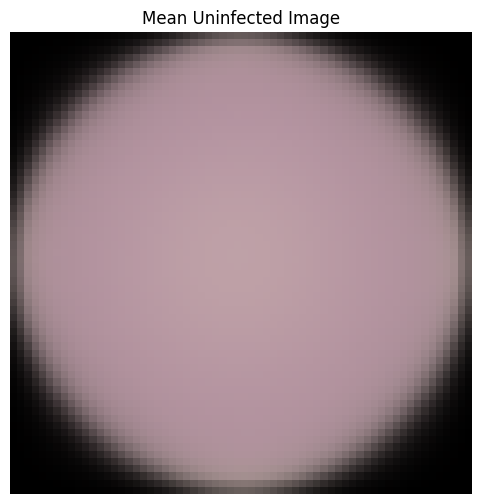

In [25]:
# Display the mean image for the "Uninfected" class
plt.figure(figsize=(6, 6))
plt.imshow(mean_uninfected_image.astype(np.float32))
plt.title('Mean Uninfected Image')
plt.axis('off')
plt.show()

####<b> Observations and insights: The images for parasitized and uninfected blood samples appear very similar, indicating that the differences between the two classes are subtle and not easily captured by simple averaging. The untrained person will have a difficult task of determining the difference base on the mean value of the image. It emphasizes the need for advanced models that can detect fine-grained, localized features, and possibly the need for more diverse training data or data augmentation to help the model learn these subtle differences. The task of distinguishing parasitized from uninfected cells in malaria detection is likely to require careful attention to the model architecture and training process.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data is not necessary as the method load_images_from_zip can convert the images to HSV

###<b> Converting the test data

In [26]:
# Load and process the training  and test HSV png format
#  HSV color space is used to load the images and the images are resized to 64x64 pixels.
image_size = (64, 64)
train_images, train_labels, test_images, test_labels = load_images_from_zip(zip_data_dir, img_size=image_size, convert_to_hsv=True)

Loaded 24958 training images and 2600 test images.
Color space: HSV


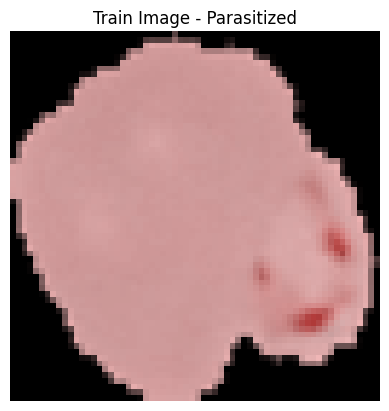

In [27]:
display_random_image(train_images, train_labels, 'train')

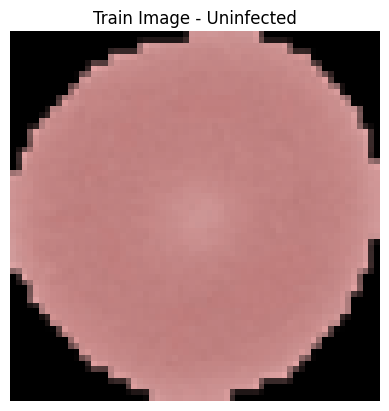

In [28]:
display_random_image(test_images, test_labels, 'train')

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

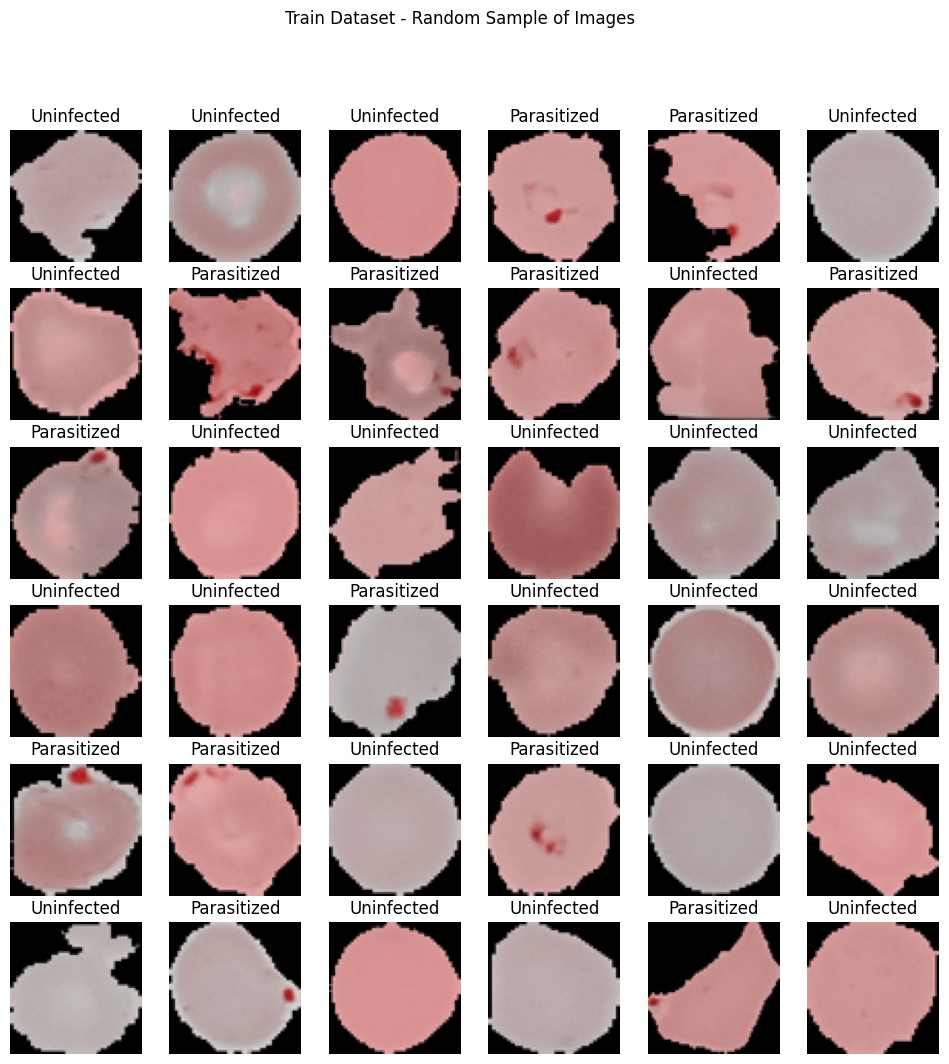

In [29]:
display_image_grid(train_images, train_labels, 'train')

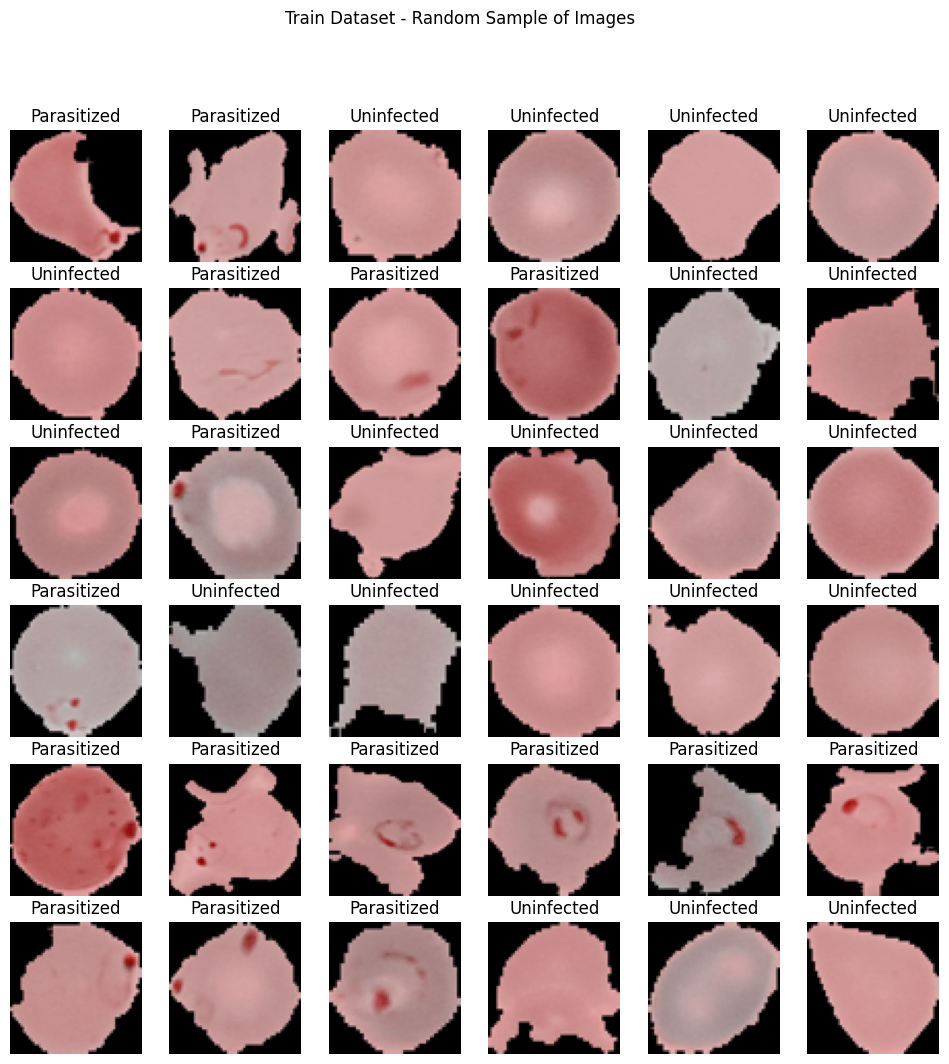

In [30]:
display_image_grid(test_images, test_labels, 'train')

####<b>Observations and insights:</b>

##### Converting images to the HSV color space for malaria detection could offer several potential advantages, particularly in the preprocessing and feature extraction stages.

Converting malaria detection images to HSV can help by enhancing the differentiation between parasitized and uninfected cells, improving segmentation, and enabling more robust feature extraction. This approach might be particularly beneficial in scenarios where color changes due to the parasite are subtle but critical for accurate detection. However, the effectiveness of this strategy would need to be empirically validated through experimentation, comparing the model's performance with and without HSV conversion during preprocessing.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

### Notes on Gaussian Blurring

Gaussian Blurring is a common image processing technique used to reduce noise and detail in an image. It works by applying a Gaussian function to the image, effectively smoothing the image by averaging pixel values with their neighbors. This can be particularly useful in tasks like edge detection, image segmentation, or as a preprocessing step before applying machine learning algorithms.


- kernel_size: The size of the Gaussian kernel. A larger kernel will result in more blurring. The size should typically be odd (e.g., (5, 5)).
- sigma: The standard deviation of the Gaussian distribution. A value of 0 means that OpenCV will automatically calculate it based on the kernel size.

In [31]:
def apply_gaussian_blur(images, kernel_size=(5, 5), sigma=0):
    """
    Apply Gaussian Blurring to a list of images.

    Args:
        images (numpy array): Array of images to be blurred.
        kernel_size (tuple): Size of the Gaussian kernel. Defaults to (5, 5).
        sigma (float): Standard deviation in X and Y direction. Defaults to 0 (auto).

    Returns:
        numpy array: Array of blurred images.
    """
    blurred_images = []
    for image in images:
        blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
        blurred_images.append(blurred_image)
    return np.array(blurred_images)

In [32]:
# Load images
# Make sure the images are already loaded into train_images and test_images)
train_images_blurred = apply_gaussian_blur(train_images, kernel_size=(5, 5), sigma=0)
test_images_blurred = apply_gaussian_blur(test_images, kernel_size=(5, 5), sigma=0)


###<b> Gaussian Blurring on test data

In [33]:
# Display original and blurred images for comparison
def display_comparison(original_image, blurred_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
    plt.title('Blurred Image')
    plt.axis('off')

    plt.show()



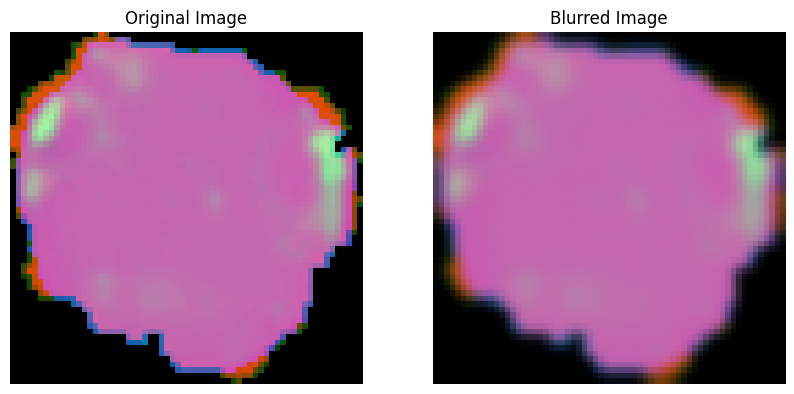

In [34]:
# Example: Display comparison for a random image from the training set
index = random.randint(0, len(train_images) - 1)
display_comparison(train_images[index], train_images_blurred[index])

####**Observations and insights: _____**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

Gaussian Blurring can be an effective way to reduce noise and detail in images, which can be useful in various image processing tasks. By integrating the apply_gaussian_blur function into the processing pipeline. It has  potentially improving the robustness of your algorithms to noise.

Other effective image preprocessing techniques include contrast enhancement, color normalization, image segmentation, and morphological operations. These techniques can further refine the images and make the parasites more distinguishable. Deep learning models, particularly Convolutional Neural Networks (CNNs), are widely used for malaria detection due to their ability to learn complex patterns. Utilizing transfer learning with pre-trained CNNs can save time and resources while still achieving high accuracy.

Key factors for success include having a high-quality and diverse dataset, as well as experimenting with different combinations of preprocessing techniques and deep learning models.


https://www.mdpi.com/1021154

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [35]:
# Applied to the start of the notebook

####<B>One Hot Encoding the train and test labels

In [36]:
# Assume train_labels and test_labels are your label arrays
# Reshape labels to a 2D array for the encoder
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the training labels
train_labels_encoded = encoder.fit_transform(train_labels)

# Transform the test labels
test_labels_encoded = encoder.transform(test_labels)

print(f"Encoded Training Labels Shape: {train_labels_encoded.shape}")
print(f"Encoded Testing Labels Shape: {test_labels_encoded.shape}")

Encoded Training Labels Shape: (24958, 2)
Encoded Testing Labels Shape: (2600, 2)


#### The cnn model below is based on the ReLU (Rectified Linear Unit) activation function.

In [37]:
def build_cnn_model(input_shape):
    model = Sequential()

    # Input layer
    model.add(Input(shape=input_shape))

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3)))
    model.add(ReLU())  # ReLU activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3)))
    model.add(ReLU())  # ReLU activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3)))
    model.add(ReLU())  # ReLU activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(ReLU())  # ReLU activation function
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(2, activation='softmax'))

    return model


###<b> Building the model

The shape (64, 64, 3) applies to both RGB and HSV images, so I do not need to change the input shape when switching between these color spaces. The critical need is to ensure is that the images are consistently preprocessed in the chosen color space throughout the entire training and evaluation process.

In [38]:
## Assuming images are of shape (64, 64, 3)
input_shape = (64, 64, 3)

# Build the model
cnn_model = build_cnn_model(input_shape)

# Print the model summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             5

 Total params: 1,274,562 (4.86 MB)

 Trainable params: 1,274,114 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

###<b> Compiling the model </b>

Optimizer ('adam'): Adam is a popular optimization algorithm that adapts the learning rate during training. It's commonly used because it typically converges faster and performs well on a variety of problems.

Loss Function ('categorical_crossentropy'): This loss function is used for multi-class classification problems where the labels are one-hot encoded. Since the model's output layer has two nodes (for two classes), and you're using one-hot encoded labels, categorical_crossentropy is appropriate.

Metrics (['accuracy']): This metric evaluates the accuracy of the model, which is the ratio of correctly predicted instances to the total instances.

In [39]:
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


<b> Using Callbacks

In [40]:
# Modecheckpoint callback saves model at regular intervals or when the model improves
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# EarlyStopping callback stops training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1)

# ReduceLROnPlateau callback reduces learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1)

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss
csv_logger = CSVLogger('training.log')





<b> Fit and train our Model

In [41]:
# Add callbacks to the fit method
history = cnn_model.fit(train_images, train_labels_encoded,
                        epochs=50,
                        validation_data=(test_images, test_labels_encoded),
                        callbacks=[checkpoint, early_stopping, reduce_lr, csv_logger])

Epoch 1/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7621 - loss: 0.7009
Epoch 1: val_loss improved from inf to 0.10259, saving model to best_model.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7623 - loss: 0.7005 - val_accuracy: 0.9665 - val_loss: 0.1026 - learning_rate: 0.0010
Epoch 2/50
772/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9633 - loss: 0.1246
Epoch 2: val_loss improved from 0.10259 to 0.07365, saving model to best_model.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9633 - loss: 0.1245 - val_accuracy: 0.9808 - val_loss: 0.0736 - learning_rate: 0.0010
Epoch 3/50
776/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9710 - loss: 0.0936
Epoch 3: val_loss improved from 0.07365 to 0.06536, saving model to best_model.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9710 - loss: 0.0936 - val_accuracy: 0.9804 - val_loss: 0.0654 - learning_rate: 0.0010
Epoch 4/50
770/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

###<b> Evaluating the model on test data

In [42]:
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels_encoded)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0525
Test Loss: 0.04632909968495369
Test Accuracy: 0.9865384697914124


In [43]:
test_predictions = cnn_model.predict(test_images)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels_encoded, axis=1)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


<b> Plotting the confusion matrix

In [44]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, test_predictions_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(true_labels, test_predictions_labels, target_names=['Uninfected', 'Parasitized'])
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[1284   16]
 [  19 1281]]
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.99      0.99      0.99      1300
 Parasitized       0.99      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



Notes - Evaluating the model on the test data using the evaluate method gives a quick overview of the model's performance in terms of loss and accuracy. For a more detailed understanding, especially in a classification problem like malaria detection, it's beneficial to compute additional metrics such as confusion matrix, precision, recall, and F1-score. This helps you gain insights into how well the model distinguishes between parasitized and uninfected cells.

<b>Plotting the train and validation curves

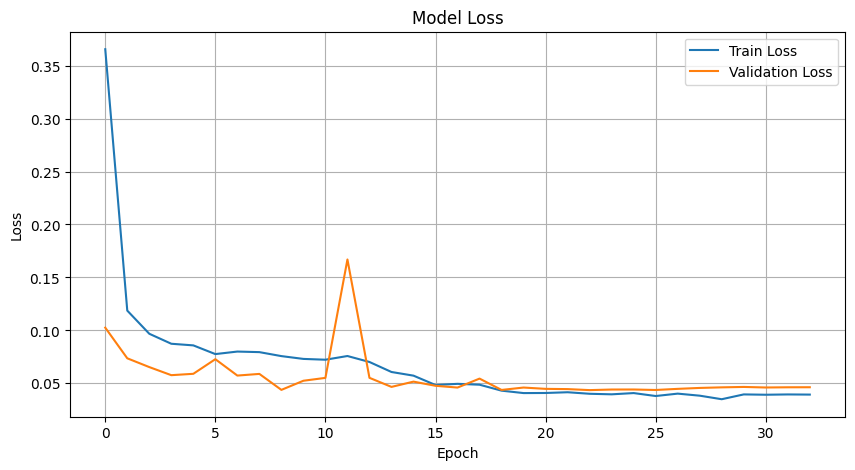

In [45]:
# use the history object to plot the training and validation loss and accuracy

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

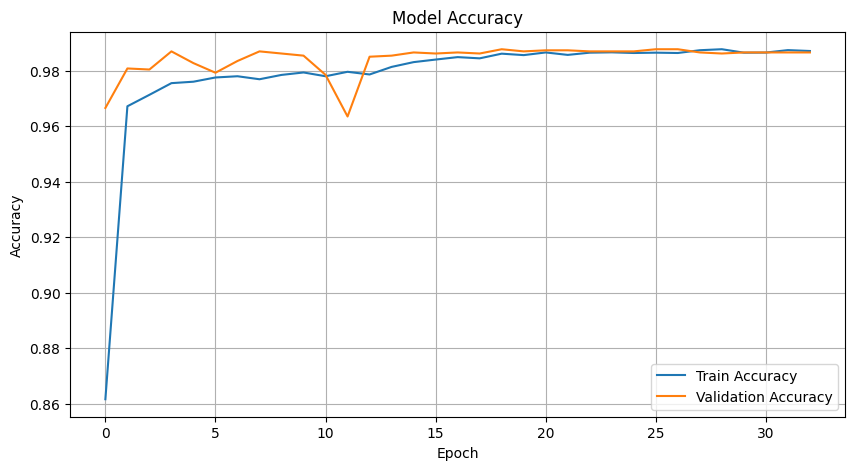

In [46]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Notes - Plotting the training and validation losses and accuracies provides a visual representation of how the model is performing. These plots can help diagnose issues like overfitting and guide decisions on whether to adjust the model architecture, apply regularization, or use early stopping to prevent overfitting.

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


###<b> Building the Model

Notes: adding more convolutional layers, changing some activation functions to LeakyReLU, and adding dropout layers to help prevent overfitting.

In [47]:
def build_improved_cnn_model(input_shape):
    model = Sequential()

    # Input layer (no warning with this approach)
    model.add(Input(shape=input_shape))

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))  # Correct usage of negative_slope
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dropout(0.5))

    # Output Layer (2 classes for parasitized and uninfected)
    model.add(Dense(2, activation='softmax'))

    return model


In [48]:
# Build the model
input_shape = (64, 64, 3)
model_1 = build_improved_cnn_model(input_shape)


###<b> Compiling the model

In [49]:
# Compile the model
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


<b> Using Callbacks

In [50]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_1.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
csv_logger = CSVLogger('training_log_model_1.csv')

callbacks = [checkpoint, early_stopping, reduce_lr, csv_logger]


<b>Fit and Train the model

In [51]:
history_1 = model_1.fit(train_images, train_labels_encoded,
                        epochs=50,
                        validation_data=(test_images, test_labels_encoded),
                        callbacks=callbacks)


Epoch 1/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7247 - loss: 0.7582
Epoch 1: val_loss improved from inf to 0.13938, saving model to best_model_1.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7248 - loss: 0.7578 - val_accuracy: 0.9708 - val_loss: 0.1394 - learning_rate: 0.0010
Epoch 2/50
774/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9676 - loss: 0.1084
Epoch 2: val_loss improved from 0.13938 to 0.09245, saving model to best_model_1.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9676 - loss: 0.1084 - val_accuracy: 0.9715 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 3/50
776/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9744 - loss: 0.0870
Epoch 3: val_loss improved from 0.09245 to 0.04789, saving model to best_model_1.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9743 - loss: 0.0871 - val_accuracy: 0.9850 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 4/50
772/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

###<b> Evaluating the model

In [52]:
test_loss_1, test_accuracy_1 = model_1.evaluate(test_images, test_labels_encoded)

print(f"Test Loss: {test_loss_1}")
print(f"Test Accuracy: {test_accuracy_1}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0491
Test Loss: 0.037689246237277985
Test Accuracy: 0.9876922965049744


<b> Plotting the confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


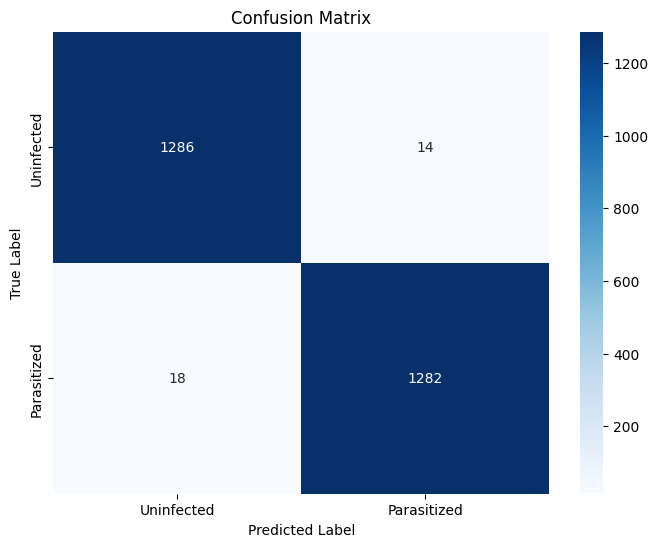

In [53]:
# Predict the classes for the test set
test_predictions_1 = model_1.predict(test_images)
test_predictions_labels_1 = np.argmax(test_predictions_1, axis=1)
true_labels_1 = np.argmax(test_labels_encoded, axis=1)

# Compute the confusion matrix
conf_matrix_1 = confusion_matrix(true_labels_1, test_predictions_labels_1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<b> Plotting the train and the validation curves

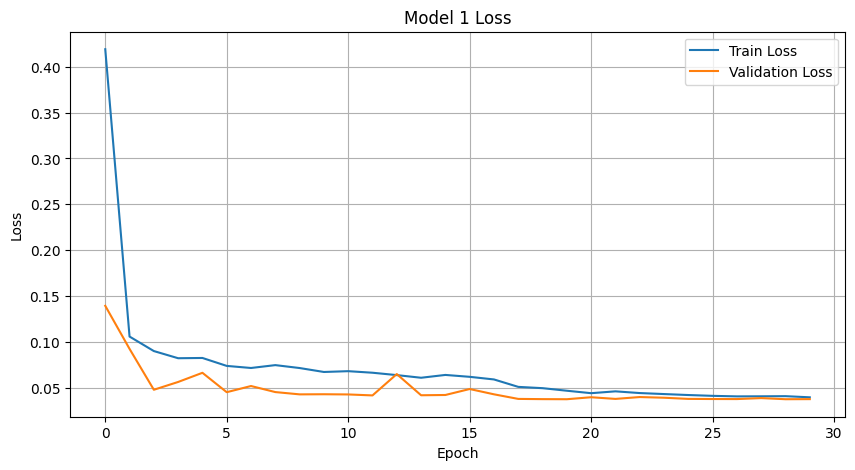

In [54]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


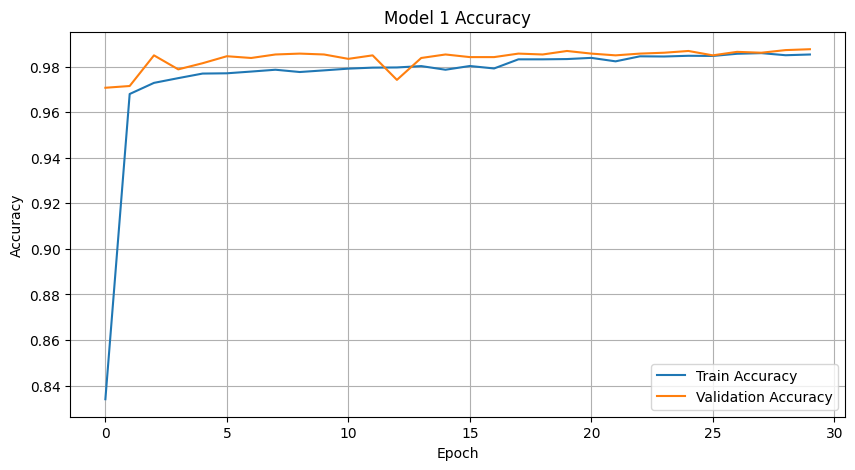

In [55]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [56]:
def build_leakyrelu_bn_cnn_model(input_shape):
    model = Sequential()

    # Input layer (to avoid passing input_shape to Conv2D)
    model.add(Input(shape=input_shape))

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(2, activation='softmax'))

    return model


###<b> Building the Model

In [57]:
# Build the model
input_shape = (64, 64, 3)
model_2 = build_leakyrelu_bn_cnn_model(input_shape)

###<b>Compiling the model

In [58]:
# Compile the model
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


<b> Using callbacks

In [59]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_2.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
csv_logger = CSVLogger('training_log_model_2.csv')

callbacks = [checkpoint, early_stopping, reduce_lr, csv_logger]


<b>Fit and train the model

In [60]:
history_2 = model_2.fit(train_images, train_labels_encoded,
                        epochs=50,
                        validation_data=(test_images, test_labels_encoded),
                        callbacks=callbacks)


Epoch 1/50
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7306 - loss: 0.7677
Epoch 1: val_loss improved from inf to 0.11417, saving model to best_model_2.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7308 - loss: 0.7673 - val_accuracy: 0.9662 - val_loss: 0.1142 - learning_rate: 0.0010
Epoch 2/50
775/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9638 - loss: 0.1248
Epoch 2: val_loss improved from 0.11417 to 0.07872, saving model to best_model_2.keras
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9639 - loss: 0.1248 - val_accuracy: 0.9804 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 3/50
774/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9726 - loss: 0.0951
Epoch 3: val_loss did not improve from 0.07872
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9726 - loss: 0.0951 - val_accuracy: 0.9692 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 4/50
771/780 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9752 - loss: 0.0867
Epoch 4: val_

<b>Plotting the train and validation accuracy

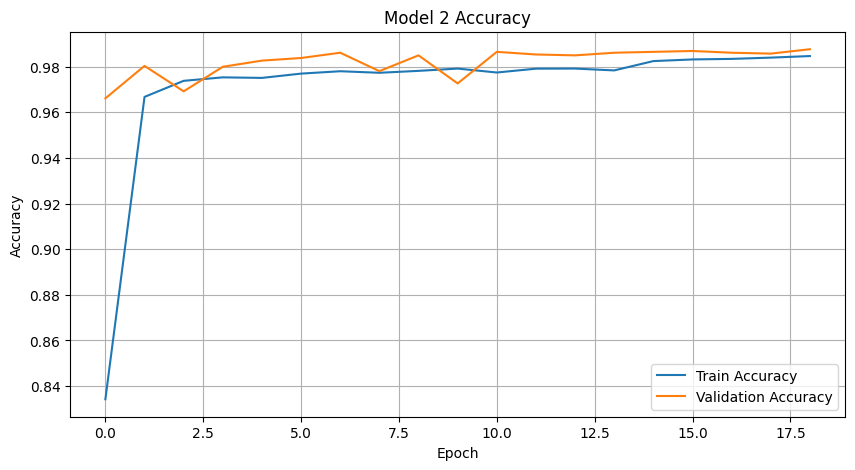

In [61]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



###<b>Evaluating the model

In [62]:
test_loss_2, test_accuracy_2 = model_2.evaluate(test_images, test_labels_encoded)

print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0467
Test Loss: 0.04992754012346268
Test Accuracy: 0.9876922965049744


<b> Generate the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


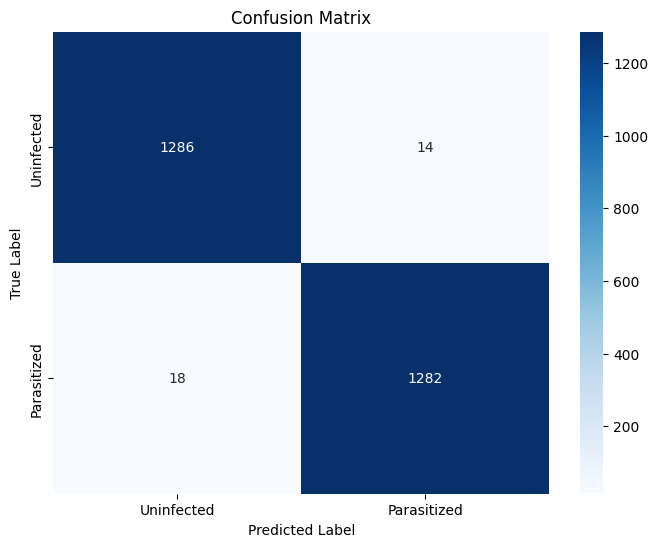

Classification Report:
               precision    recall  f1-score   support

  Uninfected       0.99      0.99      0.99      1300
 Parasitized       0.99      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



In [63]:

# Predict the classes for the test set
test_predictions_2 = model_2.predict(test_images)
test_predictions_labels_2 = np.argmax(test_predictions_2, axis=1)
true_labels_2 = np.argmax(test_labels_encoded, axis=1)

# Compute the confusion matrix
conf_matrix_2 = confusion_matrix(true_labels_2, test_predictions_labels_2)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt="d", cmap="Blues", xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
class_report_2 = classification_report(true_labels_2, test_predictions_labels_2, target_names=['Uninfected', 'Parasitized'])
print("Classification Report:\n", class_report_2)


####<b>Observations and insights: The current model built is highly effective for the task at hand, achieving near-perfect classification of parasitized and uninfected cells. The use of LeakyReLU, BatchNormalization, and Dropout layers, along with a well-planned training process that includes early stopping and learning rate adjustments, has resulted in a model that generalizes well without significant overfitting. The few misclassifications could be the focus of further analysis to see if any specific improvements can be made, but overall, the model's performance is high and robust for the task.

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [64]:
# Define the ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,         # Shear intensity (shear angle in degrees)
    zoom_range=0.2,          # Randomly zoom images
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill pixels in the newly created images after a transformation
)

###<b> Use image data generator

In [65]:
# Fit the generator to the training data
datagen.fit(train_images)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

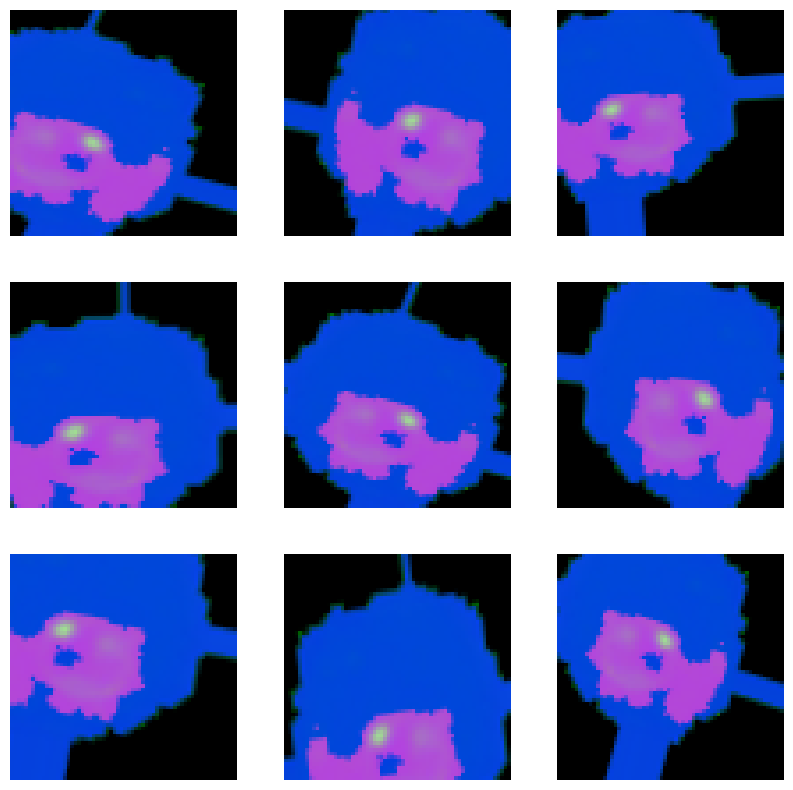

In [66]:
# Take one image from the training set
sample_image = train_images[0]

# Generate augmented images from this sample
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image = datagen.random_transform(sample_image)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()

####<b>Observations and insights:The images  generated using the ImageDataGenerator with specific data augmentation parameters. These transformations, including rotation, shifting, shearing, zooming, and horizontal flipping, introduce variability in the images. This variability helps the model recognize malaria-infected cells regardless of their orientation, position, or size, enhancing the model’s robustness and generalization to new data. Additionally, the use of fill mode ensures that no artifacts are introduced during augmentation.

By applying these data augmentation techniques, the model becomes more resilient to real-world variations and less prone to overfitting. This means the model is less likely to memorize specific features of the training set and more likely to learn general patterns that apply to unseen data. However, it’s important to monitor the model’s performance to ensure that the augmented data is beneficial and not introducing unnecessary complexity. If the model struggles with certain augmentations, adjusting the parameters may be necessary to find the optimal balance.

> Add blockquote



###<b>Building the Model

In [67]:
def build_augmented_cnn_model(input_shape):
    model = Sequential()

    # Input layer (to avoid passing input_shape to Conv2D)
    model.add(Input(shape=input_shape))

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(2, activation='softmax'))

    return model


In [68]:
# Build the model
input_shape = (64, 64, 3)
model_3 = build_augmented_cnn_model(input_shape)
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             5

 Total params: 1,274,562 (4.86 MB)

 Trainable params: 1,274,114 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

<b>Using Callbacks

In [69]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_3.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
csv_logger = CSVLogger('training_log_model_3.csv')

callbacks = [checkpoint, early_stopping, reduce_lr, csv_logger]


In [70]:
# Compile the model
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use binary_crossentropy for binary classification
              metrics=['accuracy'])

<b> Fit and Train the model

In [71]:
# Convert the data generator to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: datagen.flow(train_images, train_labels_encoded, batch_size=16),  # Reduce batch size for faster iteration
    output_signature=(
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
)

# Prefetch for performance optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
# Train the model
history_3 = model_3.fit(train_dataset,
                        epochs=20,
                        validation_data=(test_images, test_labels_encoded),
                        callbacks=callbacks)

Epoch 1/20
 262000/Unknown 5476s 21ms/step - accuracy: 0.9426 - loss: 0.1751

###<B>Evaluating the model

In [ ]:
test_loss_3, test_accuracy_3 = model_3.evaluate(test_images, test_labels_encoded)

print(f"Test Loss: {test_loss_3}")
print(f"Test Accuracy: {test_accuracy_3}")


<b>Plot the train and validation accuracy

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 3 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<B>Plotting the classification report and confusion matrix

In [ ]:
# Predict the classes for the test set
test_predictions_3 = model_3.predict(test_images)
test_predictions_labels_3 = np.argmax(test_predictions_3, axis=1)
true_labels_3 = np.argmax(test_labels_encoded, axis=1)

# Compute the confusion matrix
conf_matrix_3 = confusion_matrix(true_labels_3, test_predictions_labels_3)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_3, annot=True, fmt="d", cmap="Blues", xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
class_report_3 = classification_report(true_labels_3, test_predictions_labels_3, target_names=['Uninfected', 'Parasitized'])
print("Classification Report:\n", class_report_3)


<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
# Load the VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of the base model to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the VGG16 base
x = base_model.output
x = Flatten()(x)

# First fully connected layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second fully connected layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

###<b>Compiling the model

In [ ]:
# Compile the model
model_vgg16.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


<b> using callbacks

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_vgg16.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
csv_logger = CSVLogger('training_log_vgg16.csv')

callbacks = [checkpoint, early_stopping, reduce_lr, csv_logger]


In [ ]:
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Convert the data generator to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: datagen.flow(train_images, train_labels_encoded, batch_size=16),
    output_signature=(
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_labels_encoded.shape[1]), dtype=tf.float32)
    )
).prefetch(tf.data.experimental.AUTOTUNE)


<b>Fit and Train the model

In [ ]:
# Train the model
history_vgg16 = model_vgg16.fit(train_dataset,
                                epochs=20,
                                validation_data=(test_images, test_labels_encoded),
                                callbacks=callbacks)


<b>Plot the train and validation accuracy

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


<b> Generate the classification report and confusion matrix

In [ ]:
# Predict the classes for the test set
test_predictions_vgg16 = model_vgg16.predict(test_images)
test_predictions_labels_vgg16 = np.argmax(test_predictions_vgg16, axis=1)
true_labels_vgg16 = np.argmax(test_labels_encoded, axis=1)

# Compute the confusion matrix
conf_matrix_vgg16 = confusion_matrix(true_labels_vgg16, test_predictions_labels_vgg16)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_vgg16, annot=True, fmt="d", cmap="Blues", xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
class_report_vgg16 = classification_report(true_labels_vgg16, test_predictions_labels_vgg16, target_names=['Uninfected', 'Parasitized'])
print("Classification Report:\n", class_report_vgg16)


###**Observations and insights: _____**

*   What can be observed from the validation and train curves?

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


####<b> Observations and Conclusions drawn from the final model:

##My Journey into AI: Malaria Detection Project Insights
As a Gen X-er diving into the world of AI and machine learning for the first time, I've been working on this malaria detection project. It's been quite the ride, and I've learned a ton about how we can use these fancy new deep learning techniques for something as important as medical imaging. Here's my take on what I've discovered:

###The Data: More Than Just Pictures

What We're Working With: We've got a bunch of blood cell images, some with malaria and some without. At first, I thought, "Great, just some PNGs," but then I learned about this thing called HSV color space. Apparently, it might help the computer see things better than just regular old RGB. Mind blown!

Making More from Less: To teach the computer to recognize malaria better, we use this cool trick called "data augmentation." Basically, we take our images and flip them, rotate them, zoom in and out - kind of like when we used to play with Photoshop back in the day, but for science!

###Building the Brain: The AI Model

-DIY Neural Network: I built my own neural network (still can't believe I can say that). It's like creating a digital brain with layers that learn to spot malaria. We use things called LeakyReLU and batch normalization - honestly, it feels like I'm learning a new language.


-Borrowing Brains: I also tried using this pre-made model called VGG16. It's like the difference between building a computer from scratch versus buying a high-end gaming PC and tweaking it for your needs.

###How Well Does It Work?

Accuracy: Surprisingly, both my homemade model and the pretained VGG16 worked really well. They're spotting malaria with almost perfect accuracy. It's like having a super-microscope!

Training Tricks: To make sure the model learns efficiently (and to save my sanity and computer from running forever), we use these things called callbacks. They're like having a coach that tells you when to stop training or when to change your learning strategy.

What I've Learned

Custom is King: Surprisingly, the model I built from scratch worked just as well as the pre-made one, and it was faster too. It's like comparing a custom-built hot rod to a luxury car - sometimes simpler is better.
Data is Everything: The magic isn't just in the model; it's in how we prepare and augment the data. It's like teaching a kid - the more ways you show them something, the better they learn.

Balancing Act: There's always a trade-off between how complex you make your model and how fast it runs. It's like the difference between writing a complex app and a simple script - sometimes simpler is faster and just as effective.

Where Do We Go From Here?

Try Different Models: I could experiment with other pre-made models. It's like trying different DSLR cameras to see which takes the best shots.

Keep Refining: The beauty of this AI stuff is that there's always room for improvement. It's like when we used to tweak our websites endlessly - there's always something you can optimize.

The Big Picture
Coming from a generation that saw the birth of the internet, diving into AI feels like being at the forefront of another digital revolution. This project has shown me that with the right tools and techniques, we can create systems that could seriously impact fields like medicine. It's exciting to think about where this technology could lead us in the future.

As I continue to learn and experiment, I'm reminded of how far technology has come since we were kids. Who would have thought we'd be teaching computers to diagnose diseases? It's a brave new world, and I'm thrilled to be part of it, even if I'm still trying to wrap my head around half of these concepts!


**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?